# Machine Learning phases of matter

## Abstract
This project aims to reobtain the results presented in [Machine learning phases of matter (Juan Carrasquilla, Roger G. Melko)](https://arxiv.org/abs/1605.01735) regarding the two-dimensional square Ising model. The authors show that a standard _feed-forward neural network_ (FFNN) is a suitable tool to detect Ising's model phase transition.  
This is done by first comparing the behavior of a _fully connected neural networr_ (FCNN) to a hand-made Toy model.  
Then the number of parameters of the FCNN is increased and the accuracy of the model is studied as a function of the lattice size to remove boundary effects.   In the original article, the FCNN is then upgraded to a _convolutional neural network_ to test its accuracy on non-Ising Hamiltonians.  
Finally, as an appendix, the original data is analyzed with the _t-stochastic neighbors embedding_ algorithm to separate the data into clusters.

The full project can be found on GitHub: [https://github.com/NerusSkyhigh/Machine-Learning-Phases-of-Matter](https://github.com/NerusSkyhigh/Machine-Learning-Phases-of-Matter).

---

The fourth notebook will try to implement the content of _Appendix B: Visualizing the action of a neural network on the Ising ferromagnet_ by using sklearn's implementation of t-SNE on the data sampled using Monte Carlo.

In [ ]:
!rm -rf sample_data Machine-Learning-Phases-of-Matter MonteCarloSampling
!git clone https://github.com/NerusSkyhigh/Machine-Learning-Phases-of-Matter

# Compile C source codes
!gcc -Wall Machine-Learning-Phases-of-Matter/MonteCarloSampling.c -o MonteCarloSampling.o -lm

Cloning into 'Machine-Learning-Phases-of-Matter'...
remote: Enumerating objects: 135, done.
remote: Counting objects: 100% (135/135), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 135 (delta 59), reused 106 (delta 33), pack-reused 0
Receiving objects: 100% (135/135), 3.40 MiB | 4.05 MiB/s, done.
Resolving deltas: 100% (59/59), done.


In [ ]:
#@markdown Load libraries and helper functions
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

sns.set_theme(rc={'figure.figsize':(22,6)}, style='darkgrid')

# CONSTANTS
critical_temperature = 2/( np.log( np.sqrt(2)+1) )

# FUNCTIONS
def generate_data(lowest_temperature, increment_temperature, highest_temperature,
                  lattice_side, number_of_configurations,
                  initial_number_of_thermalisation_steps, number_of_thermalisation_steps,
                  filename='data.csv', clear_old_data=True, show_termalisation_info=False):
  # ! This version supports the "initial_number_of_thermalisation_steps" parameter
  debug_flag = "" if show_termalisation_info else "1>/dev/null"
  clear_flag = f"rm -rf {filename}" if clear_old_data else ""

  sh = f"""
  set -e
  export LC_NUMERIC="en_US.UTF-8"

  {clear_flag}

  for T in $(seq {lowest_temperature} {increment_temperature} {highest_temperature})
  do
    ./MonteCarloSampling.o --lattice-side {lattice_side} \
                          --temperature $T \
                          --number-of-configurations {number_of_configurations} \
                          --initial_thermalisation-steps {initial_number_of_thermalisation_steps} \
                          --thermalisation-steps {number_of_thermalisation_steps} \
                          --output-file '{filename}' {debug_flag}
  done
  """
  with open('script.sh', 'w') as file:
    file.write(sh)

  !bash script.sh && rm script.sh

def dataframe_from_lattice_csv(fileName, lattice_side):
  df = pd.read_csv(fileName, names=['L', 'T', 'E']+['LP'+str(i) for i in range(lattice_side*lattice_side)] )

  df['lattice'] = df[df.columns[3:]].apply( lambda x: np.array(x, dtype=np.float32), axis=1)
  df = df.drop(columns=['L']+['LP'+str(i) for i in range(lattice_side*lattice_side)])
  df['magnetization']  = df['lattice'].apply(lambda x: x.sum()/x.shape[0])

  return df

## 04 - t-SNE

### Theory
**t-distributed Stochastic Neighbor Embedding**, t-SNE in short is a non-linear technique for dimensionality reduction introduced by [Laurens van der Maaten](https://lvdmaaten.github.io/tsne/) in 2014. It works by projecting a high dimensionality space into a lower dimensional manifold _preserving as close as possible_ relative distances between points. In other words, t-SNE will try to keep distant points distant and close points close but change the absolute distance between them. This is done by first creating a t-student distributed probability distribution of points being close in the high dimensional space, then a second t-student distributed probability that the points in the lower dimensional space are close. Considering the first as the true probability distribution and the second as the probability distribution to learn, the Kullback-Leibler divergence of the two probabilities is minimized.  

It is important to highlight that the manifold chosen by the algorithm highly depends on the parameters chosen and, as in this notebook the data is generated by Monte Carlo sampling, on the data itself. Furthermore, the cost function is non-convex so it is highly improbable that two iterations will lead to the same output. Despite that, the overall structure of the output is preserved between iterations.  

An in-depth explanation of the various parameters with a visual representation can be found [here](https://distill.pub/2016/misread-tsne/), but, in a nutshell, the meaning of the parameters is the following:

#### Perplexity
This is an abstract parameter that influences the variance of the t-distribution by balancing between a local and a global interpretation of the data. More down to earth, it is a guess about the number of close neighbors each point has.  
In this case, the parameter was set to 100, to reflect that each point should be close to the other 49 points generated at the same temperature and that, ideally, it should correlate with 50 points from the two closest temperatures.

</br>  

#### Learning rate
Same behavior as the one already discussed in the Adam optimizer. _sklearn.manifold.TSNE_ allows the possibility of an adaptive learning rate using the keyword 'auto'.

</br> 

#### Early Exaggeration
Indirectly controls the distance of the final clusters in the lower dimensional space. The early prefix indicates that this value can be changed by the algorithm itself so it is just a rough esteem.

</br> 

#### Metric
The metric chosen in this case is the [Manhattan distance](https://en.wikipedia.org/wiki/Taxicab_geometry) defined as:

$$ dist(\vec{x}, \vec{y}) = \sum_{i=0}^{N} \left| x_i-y_i\right| \qquad \text{for}\quad \vec{x}, \vec{y} \in \mathcal{R}^N$$

With this definition, it is possible to define the distance between two configurations as "the minimum number of spins that is necessary to flip in order to transform one configuration into the other".

</br> 

#### init='pca'
To speed up the algorithms it is possible to first perform a [principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis)and the pipe the result to the actual t-SNE algorithm. PCA is a  _linear_ dimensionality reduction technique that tries to maximize the variance of the point in the reduced dimensional space effectively creating some rough clusters.

In [ ]:
#@markdown Data Generation
lowest_temperature = 1 #@param {type:"number"}
highest_temperature = 3.51 #@param {type:"number"}
increment_temperature = 0.05 #@param {type:"number"}
lattice_side = 30 #@param {type:"integer"}
number_of_configurations = 50 #@param {type:"integer"}
initial_number_of_thermalisation_steps = 10000 #@param {type:"integer"}
number_of_thermalisation_steps = 5000 #@param {type:"integer"}

filename ="t-sne_data.csv"
generate_data(lowest_temperature, increment_temperature, highest_temperature,
              lattice_side, number_of_configurations,
              initial_number_of_thermalisation_steps, number_of_thermalisation_steps,
              filename, clear_old_data=True, show_termalisation_info=False)

print(f"Data Generation completed. The files are available in {filename}.")

Data Generation completed. The files are available in t-sne_data.csv.


In [ ]:
df_og = dataframe_from_lattice_csv(filename, lattice_side)

# Remove the points close to the critical temperature for clearer results
df = df_og.copy()[ (df_og['T']<2.4) | (df_og['T']>3.1)]
X = np.empty( (df['lattice'].shape[0], lattice_side*lattice_side), dtype=np.float32)
for idx, lattice in enumerate(df['lattice']):
  X[idx] = lattice

**Training**

In [ ]:
#@markdown t-SNE parameters
perplexity = 100 #@param {type:"integer", default:100}
early_exaggeration = 190 #@param {type:"integer", default:195}

In [ ]:
X_embedded  = TSNE(n_components=2, init='pca', learning_rate='auto',
                   perplexity=perplexity, early_exaggeration=early_exaggeration,
                   metric="cityblock",
                   square_distances=True, n_jobs).fit_transform(X)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


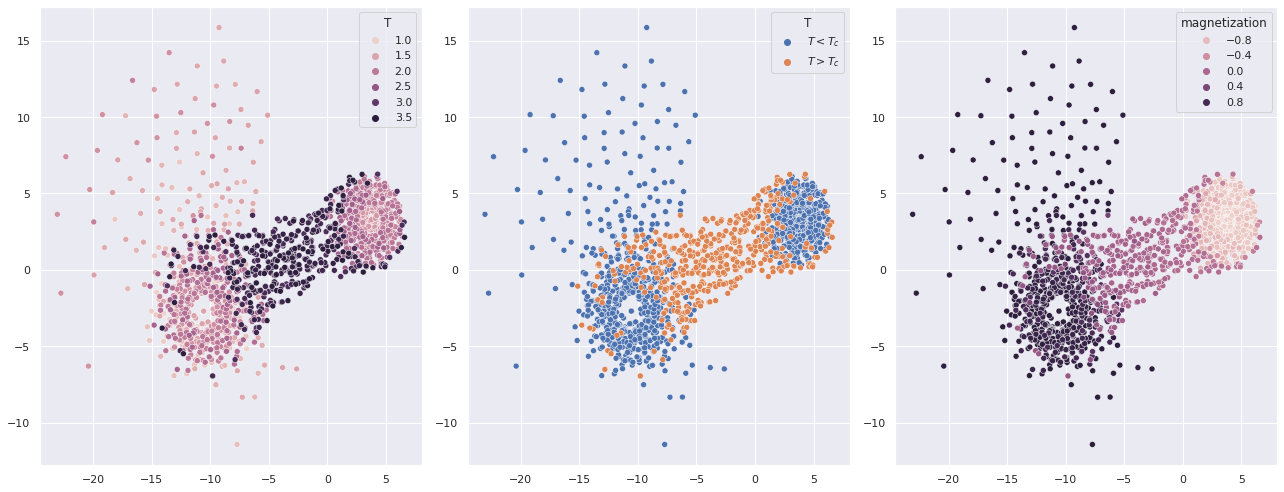

In [ ]:
#@markdown t-SNE plot with hue depending on different parameters
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 7))
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=df['T'], ax=ax[0])

hue = (df['T']>critical_temperature).map({True: r"$T>T_c$", False: r"$T<T_c$"})
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=hue, ax=ax[1])
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=df['magnetization'], ax=ax[2])
plt.tight_layout()

Although I didn't manage to obtain a plot as clear as the authors did, the main features are still present. It is possible to observe two main "cold" clusters connected by high-temperature states. This is reminiscent of the fact that the two fundamental states are connected only via the critical point and it is possible to move from one to the other only via high temperature configurations.

### Results for various values of perplexity
As t-SNE uses a non-convex cost function the plot will always look different. Some plots obtained are reported _for clarity_. As they were obtained by repetitive runs until a "good-looking" plot was produced.

#### Perplexity 100; Exageration 195
<a href="https://ibb.co/9tgwpmV"><img src="https://i.ibb.co/ySPhNmY/final-perp100-exag195.png" alt="final-perp100-exag195" border="0"></a>

#### Perplexity 100; Exageration 50; points around $T_C$ used
<a href="https://ibb.co/0BxK71p"><img src="https://i.ibb.co/1skMgBY/04-perplexity100.png" alt="04-perplexity100" border="0"></a>

#### Perplexity 50; Exageration 50; points around $T_C$ used
<a href="https://ibb.co/KwTwyVm"><img src="https://i.ibb.co/X8c8JFV/04-perplexity50.png" alt="04-perplexity50" border="0"></a>

#### Perplexity 30; Exageration 50; points around $T_C$ used
<a href="https://ibb.co/pKwh68F"><img src="https://i.ibb.co/092spSb/04-perplexity30.png" alt="04-perplexity30" border="0"></a>

#### Perplexity 10; Exageration 50; points around $T_C$ used
<a href="https://ibb.co/k2LvVyY"><img src="https://i.ibb.co/DfBTPb3/04-perplexity10.png" alt="04-perplexity10" border="0"></a>

#### Perplexity 4; Exageration 50; points around $T_C$ used
<a href="https://ibb.co/Hqd1HP0"><img src="https://i.ibb.co/L15bZgM/04-perplexity4.png" alt="04-perplexity4" border="0"></a>